# This is a Kaggle competition to predict the probability of 0 or 1 of Tabular Playground series data
## I will be comparing which model to use: XGB, Random Forest or Neural Networks


Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import initializers
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Lets download the dataset

In [80]:
df1 = pd.read_csv('C:/Users/taihs/OneDrive/Documents/tps competition/train.csv')

### Find the number of records

In [81]:
df1.shape

(300000, 32)

In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [83]:
df1.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [84]:
co = df1.corr()
co['target'].sort_values(ascending=False)

target    1.000000
cont5     0.215184
cont6     0.189832
cont8     0.183726
cont1     0.164655
cont2     0.140459
cont9     0.059242
id       -0.001407
cont0    -0.015172
cont7    -0.040646
cont10   -0.047077
cont4    -0.075585
cont3    -0.148316
Name: target, dtype: float64

In [85]:
pd.crosstab(df1['cat0'],df1['target'])

target,0,1
cat0,,
A,148852,74673
B,71687,4788


<AxesSubplot:xlabel='cat0', ylabel='target'>

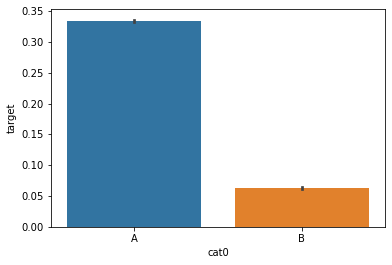

In [86]:
import seaborn as sns

sns.barplot(x=df1['cat0'],y=df1['target'])

<AxesSubplot:xlabel='cat0', ylabel='count'>

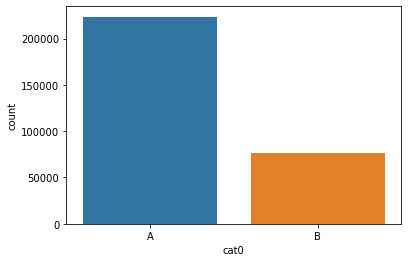

In [87]:
sns.countplot(x=df1['cat0'])

<AxesSubplot:xlabel='cat1', ylabel='target'>

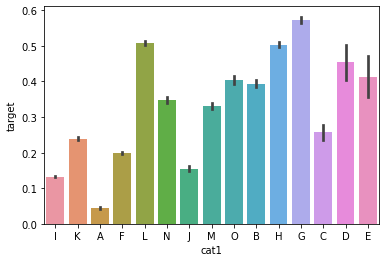

In [88]:
sns.barplot(x=df1['cat1'],y=df1['target'])

<AxesSubplot:xlabel='cat9', ylabel='Count'>

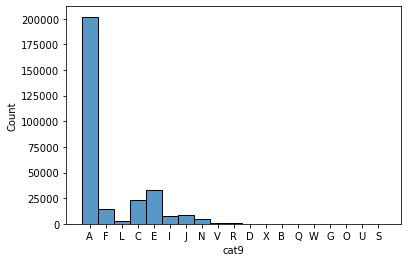

In [89]:
sns.histplot(x=df1['cat9'])

In [90]:
cat = df1.select_dtypes(include='object').columns


In [91]:
pd.crosstab(df1['target'],df1['cat0'])

cat0,A,B
target,,
0,148852,71687
1,74673,4788


In [92]:
from scipy.stats import chi2_contingency

chi2_check = []
for i in cat:
    if chi2_contingency(pd.crosstab(df1['target'], df1[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [cat, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

   Column              Hypothesis
0    cat0  Reject Null Hypothesis
1    cat1  Reject Null Hypothesis
2    cat2  Reject Null Hypothesis
3    cat3  Reject Null Hypothesis
4    cat4  Reject Null Hypothesis
5    cat5  Reject Null Hypothesis
6    cat6  Reject Null Hypothesis
7    cat7  Reject Null Hypothesis
8    cat8  Reject Null Hypothesis
9    cat9  Reject Null Hypothesis
10  cat10  Reject Null Hypothesis
11  cat11  Reject Null Hypothesis
12  cat12  Reject Null Hypothesis
13  cat13  Reject Null Hypothesis
14  cat14  Reject Null Hypothesis
15  cat15  Reject Null Hypothesis
16  cat16  Reject Null Hypothesis
17  cat17  Reject Null Hypothesis
18  cat18  Reject Null Hypothesis


In [93]:
from sklearn.preprocessing import LabelEncoder
lst = res['Column'].tolist()
le = LabelEncoder()
df3 = pd.DataFrame()
for i in lst:
    icat = le.fit_transform(df1[i])
    df2 = pd.DataFrame({i:icat})
    df3 = pd.concat([df3,df2],axis=1)
    

In [94]:
df3

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
0,0,8,0,1,1,33,0,44,54,0,258,0,0,0,0,1,3,3,1
1,0,8,0,0,4,33,8,48,3,5,162,0,1,0,1,3,1,3,1
2,0,10,0,0,4,33,0,30,38,9,69,0,1,0,0,1,3,3,1
3,0,10,0,2,4,33,0,50,3,5,241,0,0,0,0,1,3,3,1
4,0,8,6,1,4,33,2,32,54,0,75,0,0,0,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,13,5,0,4,45,0,19,48,0,159,0,0,0,1,3,1,3,1
299996,0,10,0,0,6,33,0,36,4,4,163,0,1,0,1,1,3,3,1
299997,0,6,12,0,7,33,2,37,43,0,156,1,0,0,1,3,1,3,3
299998,1,7,0,3,1,33,0,1,23,0,25,0,0,0,0,1,0,3,0


In [95]:
X = pd.concat([df3,df1[['cont0','cont1','cont2','cont3','cont4','cont5','cont6','cont7','cont8','cont9','cont10']]],axis=1)
#X = pd.concat([df3,df1[['cont1','cont2','cont5','cont6','cont8','cont9']]],axis=1)
X

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,8,0,1,1,33,0,44,54,0,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,0,8,0,0,4,33,8,48,3,5,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,0,10,0,0,4,33,0,30,38,9,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,0,10,0,2,4,33,0,50,3,5,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,0,8,6,1,4,33,2,32,54,0,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,13,5,0,4,45,0,19,48,0,...,0.500730,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007
299996,0,10,0,0,6,33,0,36,4,4,...,0.790664,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939
299997,0,6,12,0,7,33,2,37,43,0,...,0.522347,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144
299998,1,7,0,3,1,33,0,1,23,0,...,0.812891,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822


In [96]:
#X.drop(['cont0','cont9','cat3','cont10','cont7','cont8','cat5','cat7','cont3'],axis=1,inplace=True)
#X

In [97]:
X=X.astype('int')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   cat0    300000 non-null  int32
 1   cat1    300000 non-null  int32
 2   cat2    300000 non-null  int32
 3   cat3    300000 non-null  int32
 4   cat4    300000 non-null  int32
 5   cat5    300000 non-null  int32
 6   cat6    300000 non-null  int32
 7   cat7    300000 non-null  int32
 8   cat8    300000 non-null  int32
 9   cat9    300000 non-null  int32
 10  cat10   300000 non-null  int32
 11  cat11   300000 non-null  int32
 12  cat12   300000 non-null  int32
 13  cat13   300000 non-null  int32
 14  cat14   300000 non-null  int32
 15  cat15   300000 non-null  int32
 16  cat16   300000 non-null  int32
 17  cat17   300000 non-null  int32
 18  cat18   300000 non-null  int32
 19  cont0   300000 non-null  int32
 20  cont1   300000 non-null  int32
 21  cont2   300000 non-null  int32
 22  cont3   300000 non-n

### Find the features and split the data into train and test

In [59]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-5.84920296e-01, -3.98542791e-02, -6.34956934e-01,
         3.24427962e-01, -2.50936389e+00,  2.60956863e-01,
        -5.96674350e-01,  1.47628735e+00,  1.08344194e+00,
        -5.82026220e-01,  1.59106764e+00, -3.98252870e-01,
        -4.08269723e-01, -1.57791614e-01, -9.34375034e-01,
        -5.60252412e-01,  6.59684429e-01,  4.30845702e-01,
        -3.83126522e-01, -1.82574490e-03, -6.32468182e-03,
        -8.36689311e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.78795686e-02,
        -6.57414028e-02, -5.77359892e-03, -1.08018646e-02],
       [-5.84920296e-01, -3.98542791e-02, -6.34956934e-01,
        -5.20099298e-01, -5.31621538e-01,  2.60956863e-01,
         3.18564049e+00,  1.76448086e+00, -1.60044309e+00,
         1.22990528e+00,  2.81671781e-01, -3.98252870e-01,
         2.44936115e+00, -1.57791614e-01,  1.07023408e+00,
         1.57444910e+00, -1.49142537e+00,  4.30845702e-01,
        -3.83126522e-01, -1.82574490e-03, -6.32468182e-

In [98]:
from sklearn.model_selection import train_test_split

y = df1['target']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

### XGBoost

In [99]:
xgb = XGBClassifier(n_estimators=200)
xgb.fit(X_train, y_train)

C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
xgb.feature_importances_

array([0.06706327, 0.01498194, 0.01170831, 0.00534046, 0.02624277,
       0.01102255, 0.00766307, 0.00865909, 0.00895882, 0.00728115,
       0.00829969, 0.03372672, 0.01341711, 0.05380396, 0.0325352 ,
       0.06184799, 0.5215331 , 0.01997108, 0.06541748, 0.        ,
       0.00357563, 0.00081129, 0.        , 0.        , 0.        ,
       0.        , 0.00248556, 0.0136539 , 0.        , 0.        ],
      dtype=float32)

In [101]:
y_pred_class_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_xgb)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_xgb[:,1])))

accuracy is 0.843
roc-auc is 0.882


### RandomForest

In [102]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [103]:
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.830
roc-auc is 0.860


In [104]:
rf_model.feature_importances_

array([2.11293020e-02, 6.92415119e-02, 6.13450715e-02, 3.88797469e-02,
       5.46821656e-02, 2.05207805e-02, 3.95478411e-02, 1.00856660e-01,
       8.88006708e-02, 3.30349249e-02, 9.13018367e-02, 2.31932003e-02,
       8.59478594e-03, 8.02489199e-03, 2.77350148e-02, 9.23186914e-02,
       1.30679313e-01, 2.88897135e-02, 5.98572466e-02, 0.00000000e+00,
       4.86639854e-05, 2.84325805e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.54472097e-04, 1.07958061e-03,
       2.21017283e-05, 3.33795442e-05])

In [105]:
df1 = pd.read_csv('C:/Users/taihs/OneDrive/Documents/tps competition/test.csv')
df1.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,B,L,C,A,F,BI,A,E,AX,...,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,A,F,A,B,F,BI,A,AH,I,...,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [106]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
lst = res['Column'].tolist()
df3 = pd.DataFrame()
for i in lst:
    icat = le.fit_transform(df1[i])
    df2 = pd.DataFrame({i:icat})
    df3 = pd.concat([df3,df2],axis=1)


In [107]:
df3

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
0,0,5,0,0,5,33,0,8,23,0,249,0,0,0,0,1,3,3,1
1,0,7,2,0,4,2,7,31,51,0,269,0,0,0,1,3,1,3,1
2,0,13,2,0,5,2,0,8,28,0,121,0,0,0,1,1,3,3,1
3,1,11,2,0,5,33,0,30,23,0,162,0,0,0,0,1,3,1,1
4,0,5,0,1,5,33,0,8,46,0,173,0,0,0,0,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,13,0,3,5,33,0,6,23,0,75,0,0,0,1,3,1,2,1
199996,1,8,0,1,4,33,0,19,55,4,180,0,0,0,1,1,3,3,1
199997,0,11,3,0,7,33,0,14,47,0,171,0,0,0,1,3,1,3,1
199998,0,10,0,2,5,33,0,43,38,0,162,0,0,0,0,1,3,3,1


In [108]:
X = pd.concat([df3,df1[['cont0','cont1','cont2','cont3','cont4','cont5','cont6','cont7','cont8','cont9','cont10']]],axis=1)
#X = pd.concat([df3,df1[['cont1','cont2','cont5','cont6','cont8','cont9']]],axis=1)
X

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,5,0,0,5,33,0,8,23,0,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,0,7,2,0,4,2,7,31,51,0,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,0,13,2,0,5,2,0,8,28,0,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,1,11,2,0,5,33,0,30,23,0,...,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,0,5,0,1,5,33,0,8,46,0,...,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,13,0,3,5,33,0,6,23,0,...,0.361426,0.351946,0.327670,0.205547,0.679195,0.485967,0.319130,0.520681,0.519545,0.427119
199996,1,8,0,1,4,33,0,19,55,4,...,0.551106,0.628843,0.677765,0.624935,0.555306,0.242424,0.700829,0.531728,0.528427,0.922645
199997,0,11,3,0,7,33,0,14,47,0,...,0.812384,0.803348,0.324762,0.665624,0.488447,0.853213,0.578641,0.811941,0.537106,0.531758
199998,0,10,0,2,5,33,0,43,38,0,...,0.811282,0.820635,0.561449,0.797434,0.555089,0.746532,0.369986,0.438712,0.715524,0.381978


In [109]:
#X.drop(['cont0','cont9','cat3','cont10','cont7','cont8','cat5','cat7','cont3'],axis=1,inplace=True)
#X

In [110]:
X=X.astype('int')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   cat0    200000 non-null  int32
 1   cat1    200000 non-null  int32
 2   cat2    200000 non-null  int32
 3   cat3    200000 non-null  int32
 4   cat4    200000 non-null  int32
 5   cat5    200000 non-null  int32
 6   cat6    200000 non-null  int32
 7   cat7    200000 non-null  int32
 8   cat8    200000 non-null  int32
 9   cat9    200000 non-null  int32
 10  cat10   200000 non-null  int32
 11  cat11   200000 non-null  int32
 12  cat12   200000 non-null  int32
 13  cat13   200000 non-null  int32
 14  cat14   200000 non-null  int32
 15  cat15   200000 non-null  int32
 16  cat16   200000 non-null  int32
 17  cat17   200000 non-null  int32
 18  cat18   200000 non-null  int32
 19  cont0   200000 non-null  int32
 20  cont1   200000 non-null  int32
 21  cont2   200000 non-null  int32
 22  cont3   200000 non-n

In [73]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-5.84871536e-01, -1.01120305e+00, -6.36230407e-01,
        -5.18058919e-01,  1.29465996e-01,  2.65387358e-01,
        -5.97737446e-01, -1.11838839e+00, -5.52753344e-01,
        -5.86271243e-01,  1.47795544e+00, -3.98550559e-01,
        -4.10999678e-01, -1.59865185e-01, -9.35975115e-01,
        -5.62749702e-01,  6.59929099e-01,  4.28600036e-01,
        -3.85341368e-01, -2.23607357e-03, -6.32468182e-03,
        -7.74619908e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.88216841e-02,
        -6.52923950e-02, -7.07124460e-03, -1.11810387e-02],
       [-5.84871536e-01, -3.62062827e-01, -1.52758874e-01,
        -5.18058919e-01, -5.33136983e-01, -2.17765193e+00,
         2.71391909e+00,  5.37757899e-01,  9.20319820e-01,
        -5.86271243e-01,  1.75172996e+00, -3.98550559e-01,
        -4.10999678e-01, -1.59865185e-01,  1.06840447e+00,
         1.56988773e+00, -1.49372835e+00,  4.28600036e-01,
        -3.85341368e-01, -2.23607357e-03, -6.32468182e-

In [111]:
y_pred_class_rf = rf_model.predict(X)
y_pred_prob_rf = rf_model.predict_proba(X)

y_pred_class_xgb = xgb.predict(X)
y_pred_prob_xgb = xgb.predict_proba(X)

In [112]:
rf_model.feature_importances_
np.sort(xgb.feature_importances_)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00081129, 0.00248556, 0.00357563,
       0.00534046, 0.00728115, 0.00766307, 0.00829969, 0.00865909,
       0.00895882, 0.01102255, 0.01170831, 0.01341711, 0.0136539 ,
       0.01498194, 0.01997108, 0.02624277, 0.0325352 , 0.03372672,
       0.05380396, 0.06184799, 0.06541748, 0.06706327, 0.5215331 ],
      dtype=float32)

In [113]:
#y_pred_prob_rf[:,1]
y_pred_prob_xgb[:,1]

array([0.16220756, 0.30961773, 0.04213469, ..., 0.69286907, 0.03106131,
       0.6059582 ], dtype=float32)

In [114]:
#final = pd.DataFrame({'target':y_pred_prob_rf[:,1]})
final = pd.DataFrame({'target':y_pred_prob_xgb[:,1]})
final.tail()

,target
199995,0.871420
199996,0.014474
199997,0.692869
199998,0.031061
199999,0.605958


In [115]:
final1 = pd.concat([df1['id'],final],axis=1)
final1.tail()

,id,target
199995,499983,0.871420
199996,499984,0.014474
199997,499987,0.692869
199998,499994,0.031061
199999,499998,0.605958


In [116]:
final1.to_csv('sample_submission.csv',index=False)

### Train a Neural Network model with one hidden layer with sigmoid activation

In [89]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (24,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50


ValueError: in user code:

    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\taihs\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape [32, 30]


In [167]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [168]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.837
roc-auc is 0.869


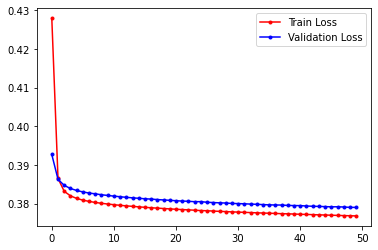

In [169]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Add two hidden layers to the Neural Networks

In [170]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (24,),activation = 'sigmoid'))
model_1.add(Dense(12,activation='sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 469
Trainable params: 469
Non-trainable params: 0
_________________________________________________________________


In [171]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
7500/7500 [==============================] - 4s 562us/step - loss: 0.5581 - accuracy: 0.7268 - val_loss: 0.5198 - val_accuracy: 0.7362
Epoch 2/50
7500/7500 [==============================] - 4s 530us/step - loss: 0.4736 - accuracy: 0.7633 - val_loss: 0.4299 - val_accuracy: 0.8266
Epoch 3/50
7500/7500 [==============================] - 4s 536us/step - loss: 0.4084 - accuracy: 0.8319 - val_loss: 0.3982 - val_accuracy: 0.8311
Epoch 4/50
7500/7500 [==============================] - 4s 536us/step - loss: 0.3932 - accuracy: 0.8326 - val_loss: 0.3925 - val_accuracy: 0.8310
Epoch 5/50
7500/7500 [==============================] - 4s 533us/step - loss: 0.3893 - accuracy: 0.8332 - val_loss: 0.3901 - val_accuracy: 0.8325
Epoch 6/50
7500/7500 [==============================] - 4s 535us/step - loss: 0.3872 - accuracy: 0.8339 - val_loss: 0.3884 - val_accuracy: 0.8328
Epoch 7/50
7500/7500 [==============================] - 4s 564us/step - loss: 0.3857 - accuracy: 0.8345 - val_loss: 0.3872 -

In [172]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.838
roc-auc is 0.869


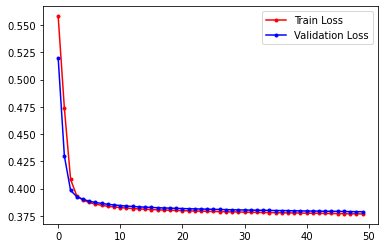

In [173]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Change to two hidden layers with activation relu

In [174]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (24,),activation = 'relu'))
model_1.add(Dense(12,activation='relu'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_8 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 13        
Total params: 469
Trainable params: 469
Non-trainable params: 0
_________________________________________________________________


In [175]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
7500/7500 [==============================] - 4s 581us/step - loss: 0.4311 - accuracy: 0.8112 - val_loss: 0.3932 - val_accuracy: 0.8306
Epoch 2/50
7500/7500 [==============================] - 4s 532us/step - loss: 0.3861 - accuracy: 0.8327 - val_loss: 0.3854 - val_accuracy: 0.8332
Epoch 3/50
7500/7500 [==============================] - 4s 534us/step - loss: 0.3815 - accuracy: 0.8349 - val_loss: 0.3825 - val_accuracy: 0.8354
Epoch 4/50
7500/7500 [==============================] - 4s 535us/step - loss: 0.3794 - accuracy: 0.8361 - val_loss: 0.3810 - val_accuracy: 0.8361
Epoch 5/50
7500/7500 [==============================] - 4s 534us/step - loss: 0.3783 - accuracy: 0.8368 - val_loss: 0.3802 - val_accuracy: 0.8361
Epoch 6/50
7500/7500 [==============================] - 4s 537us/step - loss: 0.3776 - accuracy: 0.8372 - val_loss: 0.3796 - val_accuracy: 0.8360
Epoch 7/50
7500/7500 [==============================] - 4s 541us/step - loss: 0.3771 - accuracy: 0.8374 - val_loss: 0.3792 -

In [176]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.838
roc-auc is 0.872


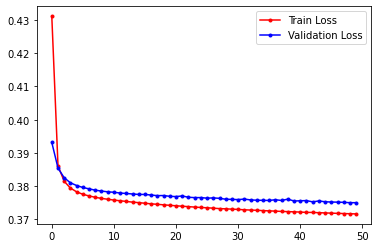

In [177]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Change to epochs 1000

In [42]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500)

Epoch 1/500
7500/7500 [==============================] - 4s 549us/step - loss: 0.3810 - accuracy: 0.8360 - val_loss: 0.3859 - val_accuracy: 0.8334
Epoch 2/500
7500/7500 [==============================] - 4s 551us/step - loss: 0.3807 - accuracy: 0.8361 - val_loss: 0.3809 - val_accuracy: 0.8354
Epoch 3/500
7500/7500 [==============================] - 6s 742us/step - loss: 0.3807 - accuracy: 0.8364 - val_loss: 0.3799 - val_accuracy: 0.8360
Epoch 4/500
7500/7500 [==============================] - 4s 559us/step - loss: 0.3809 - accuracy: 0.8364 - val_loss: 0.3798 - val_accuracy: 0.8357
Epoch 5/500
7500/7500 [==============================] - 4s 546us/step - loss: 0.3809 - accuracy: 0.8363 - val_loss: 0.3863 - val_accuracy: 0.8321
Epoch 6/500
7500/7500 [==============================] - 4s 544us/step - loss: 0.3809 - accuracy: 0.8359 - val_loss: 0.3809 - val_accuracy: 0.8365
Epoch 7/500
7500/7500 [==============================] - 4s 542us/step - loss: 0.3805 - accuracy: 0.8366 - val_loss: 0

7500/7500 [==============================] - 4s 541us/step - loss: 0.3791 - accuracy: 0.8368 - val_loss: 0.3872 - val_accuracy: 0.8328
Epoch 110/500
7500/7500 [==============================] - 4s 540us/step - loss: 0.3793 - accuracy: 0.8372 - val_loss: 0.3788 - val_accuracy: 0.8366
Epoch 111/500
7500/7500 [==============================] - 4s 544us/step - loss: 0.3789 - accuracy: 0.8371 - val_loss: 0.3773 - val_accuracy: 0.8376
Epoch 112/500
7500/7500 [==============================] - 4s 538us/step - loss: 0.3791 - accuracy: 0.8368 - val_loss: 0.3807 - val_accuracy: 0.8375
Epoch 113/500
7500/7500 [==============================] - 4s 538us/step - loss: 0.3788 - accuracy: 0.8370 - val_loss: 0.3810 - val_accuracy: 0.8354
Epoch 114/500
7500/7500 [==============================] - 4s 541us/step - loss: 0.3789 - accuracy: 0.8370 - val_loss: 0.3831 - val_accuracy: 0.8353
Epoch 115/500
7500/7500 [==============================] - 4s 546us/step - loss: 0.3789 - accuracy: 0.8374 - val_loss: 0

7500/7500 [==============================] - 5s 704us/step - loss: 0.3783 - accuracy: 0.8373 - val_loss: 0.3794 - val_accuracy: 0.8366
Epoch 165/500
7500/7500 [==============================] - 4s 579us/step - loss: 0.3783 - accuracy: 0.8368 - val_loss: 0.3808 - val_accuracy: 0.8357
Epoch 166/500
7500/7500 [==============================] - 4s 553us/step - loss: 0.3786 - accuracy: 0.8371 - val_loss: 0.3774 - val_accuracy: 0.8375
Epoch 167/500
7500/7500 [==============================] - 4s 536us/step - loss: 0.3785 - accuracy: 0.8371 - val_loss: 0.3764 - val_accuracy: 0.8378
Epoch 168/500
7500/7500 [==============================] - 4s 588us/step - loss: 0.3783 - accuracy: 0.8374 - val_loss: 0.3770 - val_accuracy: 0.8375
Epoch 169/500
7500/7500 [==============================] - 4s 587us/step - loss: 0.3785 - accuracy: 0.8369 - val_loss: 0.3766 - val_accuracy: 0.8381
Epoch 170/500
7500/7500 [==============================] - 4s 556us/step - loss: 0.3785 - accuracy: 0.8374 - val_loss: 0

7500/7500 [==============================] - 4s 542us/step - loss: 0.3776 - accuracy: 0.8373 - val_loss: 0.3798 - val_accuracy: 0.8370
Epoch 275/500
7500/7500 [==============================] - 4s 540us/step - loss: 0.3776 - accuracy: 0.8379 - val_loss: 0.3784 - val_accuracy: 0.8374
Epoch 276/500
7500/7500 [==============================] - 4s 556us/step - loss: 0.3776 - accuracy: 0.8376 - val_loss: 0.3798 - val_accuracy: 0.8367
Epoch 277/500
7500/7500 [==============================] - 4s 551us/step - loss: 0.3776 - accuracy: 0.8375 - val_loss: 0.3781 - val_accuracy: 0.8378
Epoch 278/500
7500/7500 [==============================] - 4s 540us/step - loss: 0.3776 - accuracy: 0.8377 - val_loss: 0.3800 - val_accuracy: 0.8370
Epoch 279/500
7500/7500 [==============================] - 4s 566us/step - loss: 0.3776 - accuracy: 0.8374 - val_loss: 0.3785 - val_accuracy: 0.8368
Epoch 280/500
7500/7500 [==============================] - 4s 552us/step - loss: 0.3776 - accuracy: 0.8374 - val_loss: 0

7500/7500 [==============================] - 4s 542us/step - loss: 0.3770 - accuracy: 0.8376 - val_loss: 0.3784 - val_accuracy: 0.8377
Epoch 330/500
7500/7500 [==============================] - 4s 539us/step - loss: 0.3772 - accuracy: 0.8375 - val_loss: 0.3787 - val_accuracy: 0.8375
Epoch 331/500
7500/7500 [==============================] - 4s 559us/step - loss: 0.3772 - accuracy: 0.8374 - val_loss: 0.3757 - val_accuracy: 0.8381
Epoch 332/500
7500/7500 [==============================] - 4s 548us/step - loss: 0.3772 - accuracy: 0.8379 - val_loss: 0.3774 - val_accuracy: 0.8373
Epoch 333/500
7500/7500 [==============================] - 4s 544us/step - loss: 0.3770 - accuracy: 0.8378 - val_loss: 0.3777 - val_accuracy: 0.8367
Epoch 334/500
7500/7500 [==============================] - 47s 6ms/step - loss: 0.3773 - accuracy: 0.8377 - val_loss: 0.3804 - val_accuracy: 0.8360
Epoch 335/500
7500/7500 [==============================] - 8s 1ms/step - loss: 0.3772 - accuracy: 0.8378 - val_loss: 0.37

7500/7500 [==============================] - 4s 513us/step - loss: 0.3767 - accuracy: 0.8379 - val_loss: 0.3795 - val_accuracy: 0.8360
Epoch 440/500
7500/7500 [==============================] - 4s 525us/step - loss: 0.3768 - accuracy: 0.8380 - val_loss: 0.3775 - val_accuracy: 0.8370
Epoch 441/500
7500/7500 [==============================] - 4s 511us/step - loss: 0.3767 - accuracy: 0.8377 - val_loss: 0.3786 - val_accuracy: 0.8364
Epoch 442/500
7500/7500 [==============================] - 4s 512us/step - loss: 0.3765 - accuracy: 0.8377 - val_loss: 0.3780 - val_accuracy: 0.8375
Epoch 443/500
7500/7500 [==============================] - 4s 510us/step - loss: 0.3765 - accuracy: 0.8375 - val_loss: 0.3775 - val_accuracy: 0.8373
Epoch 444/500
7500/7500 [==============================] - 4s 512us/step - loss: 0.3765 - accuracy: 0.8383 - val_loss: 0.3761 - val_accuracy: 0.8377
Epoch 445/500
7500/7500 [==============================] - 4s 509us/step - loss: 0.3767 - accuracy: 0.8377 - val_loss: 0

7500/7500 [==============================] - 4s 592us/step - loss: 0.3764 - accuracy: 0.8380 - val_loss: 0.3798 - val_accuracy: 0.8364
Epoch 495/500
7500/7500 [==============================] - 4s 568us/step - loss: 0.3766 - accuracy: 0.8376 - val_loss: 0.3762 - val_accuracy: 0.8379
Epoch 496/500
7500/7500 [==============================] - 4s 569us/step - loss: 0.3763 - accuracy: 0.8376 - val_loss: 0.3813 - val_accuracy: 0.8352
Epoch 497/500
7500/7500 [==============================] - 4s 531us/step - loss: 0.3762 - accuracy: 0.8383 - val_loss: 0.3843 - val_accuracy: 0.8347
Epoch 498/500
7500/7500 [==============================] - 4s 515us/step - loss: 0.3766 - accuracy: 0.8380 - val_loss: 0.3809 - val_accuracy: 0.8359
Epoch 499/500
7500/7500 [==============================] - 4s 511us/step - loss: 0.3764 - accuracy: 0.8382 - val_loss: 0.3825 - val_accuracy: 0.8346
Epoch 500/500
7500/7500 [==============================] - 4s 510us/step - loss: 0.3764 - accuracy: 0.8381 - val_loss: 0

In [43]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.837
roc-auc is 0.871


In [44]:
y_pred_class_nn_1 = model_1.predict_classes(X)
y_pred_prob_nn_1 = model_1.predict(X)

In [70]:
y_pred_prob_nn_1[:,0]

array([0.05876464, 0.55560994, 0.06158394, ..., 0.70166874, 0.11884412,
       0.34610277], dtype=float32)

In [71]:
final=pd.DataFrame({'target': y_pred_prob_nn_1[:,0]})
final.head()

,target
0,0.058765
1,0.555610
2,0.061584
3,0.090531
4,0.084319


In [72]:
final1 = pd.concat([df1['id'],final],axis=1)
final1.head()

,id,target
0,5,0.058765
1,6,0.555610
2,8,0.061584
3,9,0.090531
4,11,0.084319


In [73]:
final1.to_csv('sample_submission.csv',index=False)